# Dimensionality reduction and biological sequences classification. 

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import argrelextrema

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing as pr

from Bio import SeqIO
from io import StringIO
from itertools import product

from typing import Sequence

import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn

from flax.serialization import from_bytes

In [2]:
def PlotStyle(Axes): 
    """
    Parameters
    ----------
    Axes : Matplotlib axes object
        Applies a general style to the matplotlib object

    Returns
    -------
    None.
    """    
    Axes.spines['top'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.spines['right'].set_visible(False)
    Axes.xaxis.set_tick_params(labelsize=12)
    Axes.yaxis.set_tick_params(labelsize=12)

class Coder(nn.Module):
    
    Units: Sequence[int]
    name: str 
    train: bool = True 
    
    def setup(self):
        self.layers = [nn.Dense(feat,use_bias=False,name = self.name+' layer_'+str(k)) for k,feat in enumerate(self.Units)]
        self.norms = [nn.BatchNorm(use_running_average=not self.train,name = self.name+' norm_'+str(k)) for k,feat in enumerate(self.Units)]
        
    @nn.compact
    def __call__(self,inputs):
        x = inputs
        for k,block in enumerate(zip(self.layers,self.norms)):
            lay,norm = block
            x = lay(x)
            x = norm(x)
            x = nn.relu(x)
        return x

class Encoder(nn.Module):
    
    Units: Sequence[int]
    name: str 
    train: bool = True
    
    def setup(self):
        self.encoder = Coder(self.Units[1::],self.name,self.train)
        self.mean = nn.Dense(self.Units[-1], name='mean')
        self.logvar = nn.Dense(self.Units[-1], name='logvar')
    
    @nn.compact
    def __call__(self, inputs):
        
        x = inputs
        mlpencoded = self.encoder(x)
        mean_x = self.mean(mlpencoded)
        logvar_x = self.logvar(mlpencoded)
        
        return mean_x, logvar_x

class Decoder(nn.Module):
    
    Units: Sequence[int]
    name: str 
    train: bool = True
    
    def setup(self):
        self.decoder = Coder(self.Units[0:-1],self.name,self.train)
        self.out = nn.Dense(self.Units[-1],use_bias=False, name='out')
    
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        decoded_1 = self.decoder(x)
        
        out =self.out(decoded_1)
        out = nn.BatchNorm(use_running_average=not self.train,name = 'outnorm')(out)
        out = nn.sigmoid(out)
        
        return out

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

class VAE(nn.Module):
    
    Units: Sequence[int]
    name: str 
    train: bool = True
    
    def setup(self):
        self.encoder = Encoder(self.Units,self.name+'encoder',self.train)
        self.decoder = Decoder(self.Units[::-1],self.name+'decoder',self.train)

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

mainUnits  = [340,170,85,21,5,2]

def VAEModel():
    return VAE(mainUnits,'test')

Alphabet = ['A','C','T','G']
Labels = []

maxSize = 5
for k in range(1,maxSize):
    
    Labels.append([''.join(i) for i in product(Alphabet, repeat = k)])
    
KmerLabels = [item for sublist in Labels for item in sublist]

def GetSeq(path):

    with open(path) as file:
        
        seqData=file.read()
        
    Seq=StringIO(seqData)
    SeqList=list(SeqIO.parse(Seq,'fasta'))
    
    return SeqList[0]


# PCA projection

Text(0.5, 0.98, 'SARS Cov2 PCA projection')

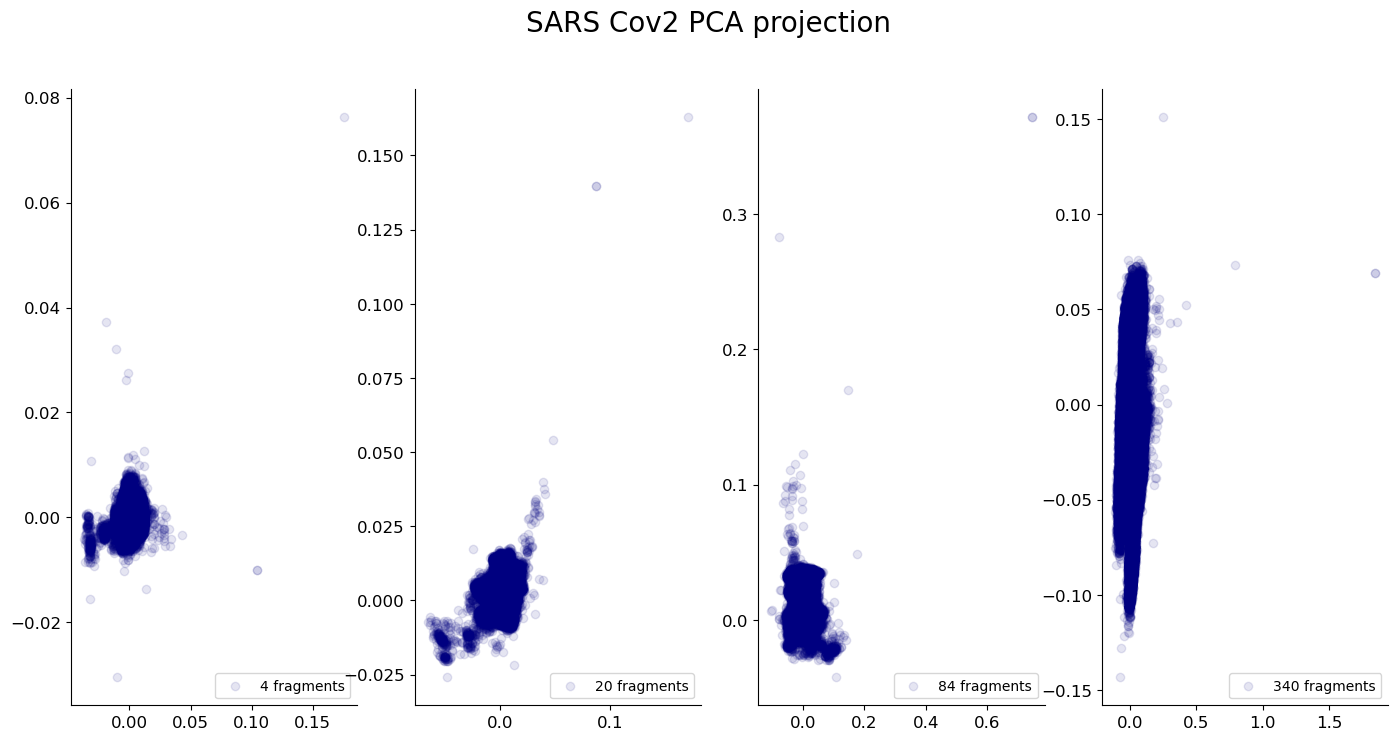

In [3]:
DataDir = '/kaggle/input/sars-cov2-fragments-frequency-small/KmerDataUpdSmall.csv'
KmerData = pd.read_csv(DataDir)
KmerData = KmerData.set_index('id')

fig,axs =  plt.subplots(1,4,figsize=(17,8))
endsize = 0
for k,lab in enumerate(Labels):
    
    endsize = endsize + len(lab)
    stlabs = KmerLabels[0:endsize]
    stdata = np.array(KmerData[stlabs])
    stdata = (stdata - stdata.min())/(stdata.max() - stdata.min())
    
    stpca = PCA(n_components=2)
    stpca.fit(stdata)
    stdata = stpca.transform(stdata)
    axs[k].scatter(stdata[:,0],stdata[:,1],alpha=0.1,color='navy',label=str(len(stlabs))+' fragments')
    axs[k].legend(loc=4)
    PlotStyle(axs[k])
fig.suptitle('SARS Cov2 PCA projection',fontsize=20)

# Autoencoder

In [4]:
headers = ['id'] + KmerLabels 

KmerData = pd.read_csv(DataDir,usecols=headers)
KmerData = KmerData.set_index('id')

MetaData = pd.read_csv('/kaggle/input/covid19-metadata/MetaData.csv')
MetaData = MetaData[MetaData['correctdata']==1]
MetaData = MetaData.set_index('id')

TrainFolds = pd.read_csv('/kaggle/input/sarscov2-trained-models-fragments/train.csv')

trainLabels = TrainFolds['Fold0']
trainData = np.array(KmerData.loc[trainLabels])    
    
Scaler = pr.MinMaxScaler()
Scaler.fit(trainData)

KmerData = KmerData.loc[MetaData.index]

KmerDataTR = Scaler.transform(np.array(KmerData))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
basePath = '/kaggle/input/sarscov2-trained-models-fragments/flax_model0'

with open(basePath, "rb") as state_f:
    state = from_bytes(VAEModel, state_f.read())
    state = jax.tree_util.tree_map(jnp.array, state)

rng = random.PRNGKey(0)
localparams = {'params':state['params']['testencoder'],'batch_stats':state['batch_stats']['testencoder']}

def EcoderModel(trainparams,batch):
    return Encoder(mainUnits,'testencoder',False).apply(trainparams, batch)

In [6]:
VariationalRep = []
Bsize = 80000
for k in range(0,len(KmerDataTR),Bsize):
    localfrag = KmerDataTR[k:k+Bsize]
    mu,logvar = EcoderModel(localparams,localfrag)
    varfrag = reparameterize(rng,mu,logvar)
    VariationalRep.append(varfrag)

VariationalRep = np.vstack(VariationalRep)

del KmerDataTR

MetaData['ldim0'] = VariationalRep[:,0]
MetaData['ldim1'] = VariationalRep[:,1]

Text(0.5, 1.0, 'SARS-Cov2 learned representation')

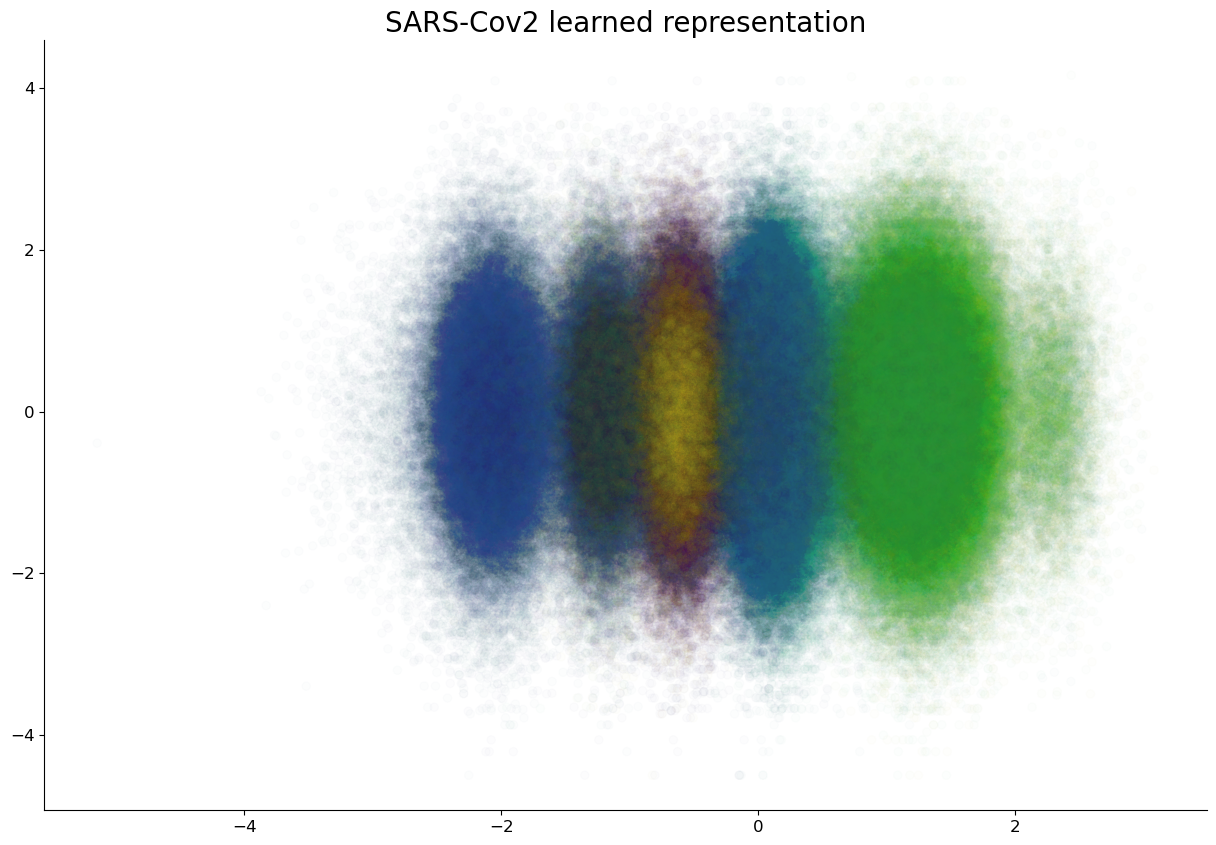

In [7]:
plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(VariationalRep[:,0],VariationalRep[:,1],alpha=0.01,c=MetaData['dayofyear'])
PlotStyle(ax)
plt.title('SARS-Cov2 learned representation',fontsize=20)

Text(0.5, 1.0, 'SARS-Cov2 learned representation and S Gene target failure')

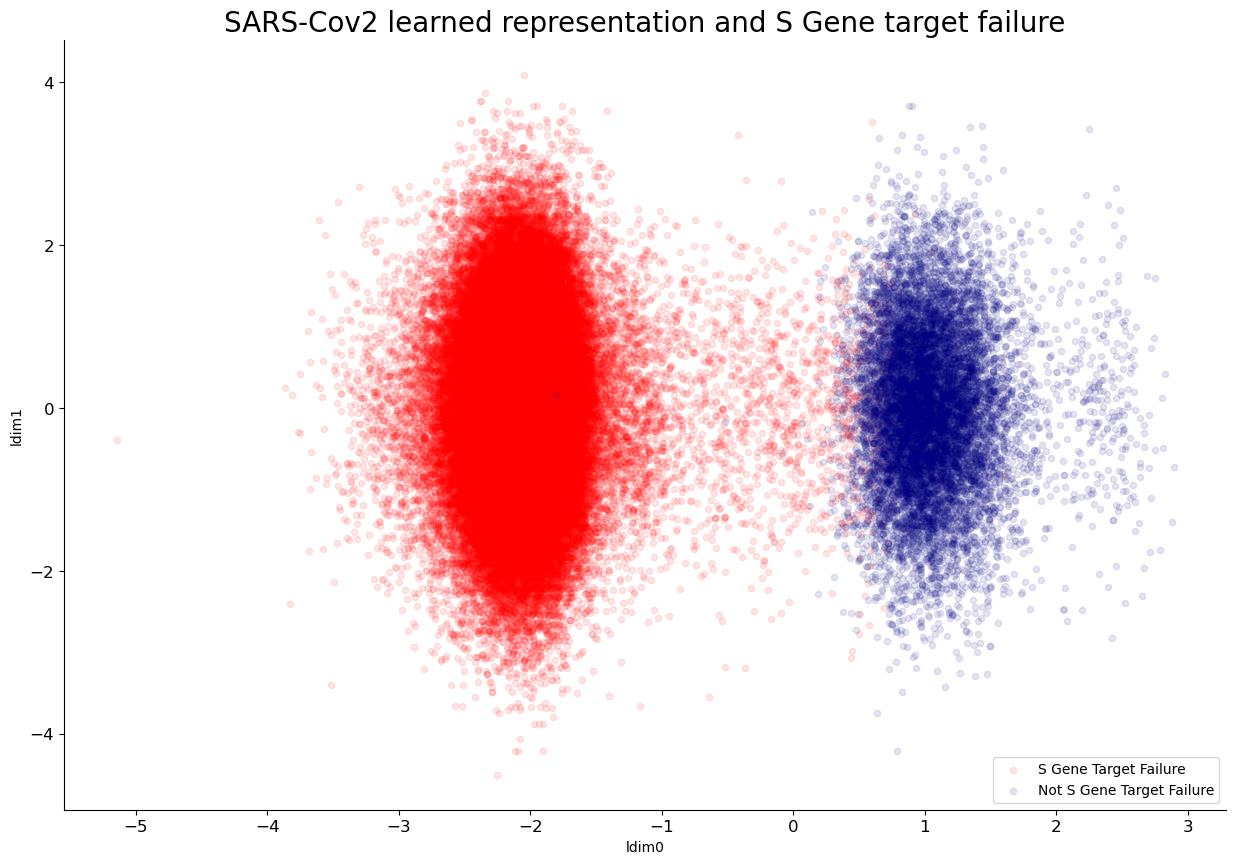

In [8]:
SGTF = MetaData[MetaData['Pangolin'] == 'B.1.1.7']

nSGTF = MetaData[MetaData['Pangolin'] == 'B.1.617.2']

plt.figure(figsize=(15,10))
ax = plt.gca()
SGTF.plot.scatter(x='ldim0',y='ldim1',ax=ax,alpha=0.1,color='red',label='S Gene Target Failure')
nSGTF.plot.scatter(x='ldim0',y='ldim1',ax=ax,alpha=0.1,color='navy',label='Not S Gene Target Failure')
ax.legend(loc=4)
PlotStyle(ax)
plt.title('SARS-Cov2 learned representation and S Gene target failure',fontsize=20)

# Sequences Analysis 

Text(0.5, 0.98, 'SARS-Cov2 VAE learned time scale ')

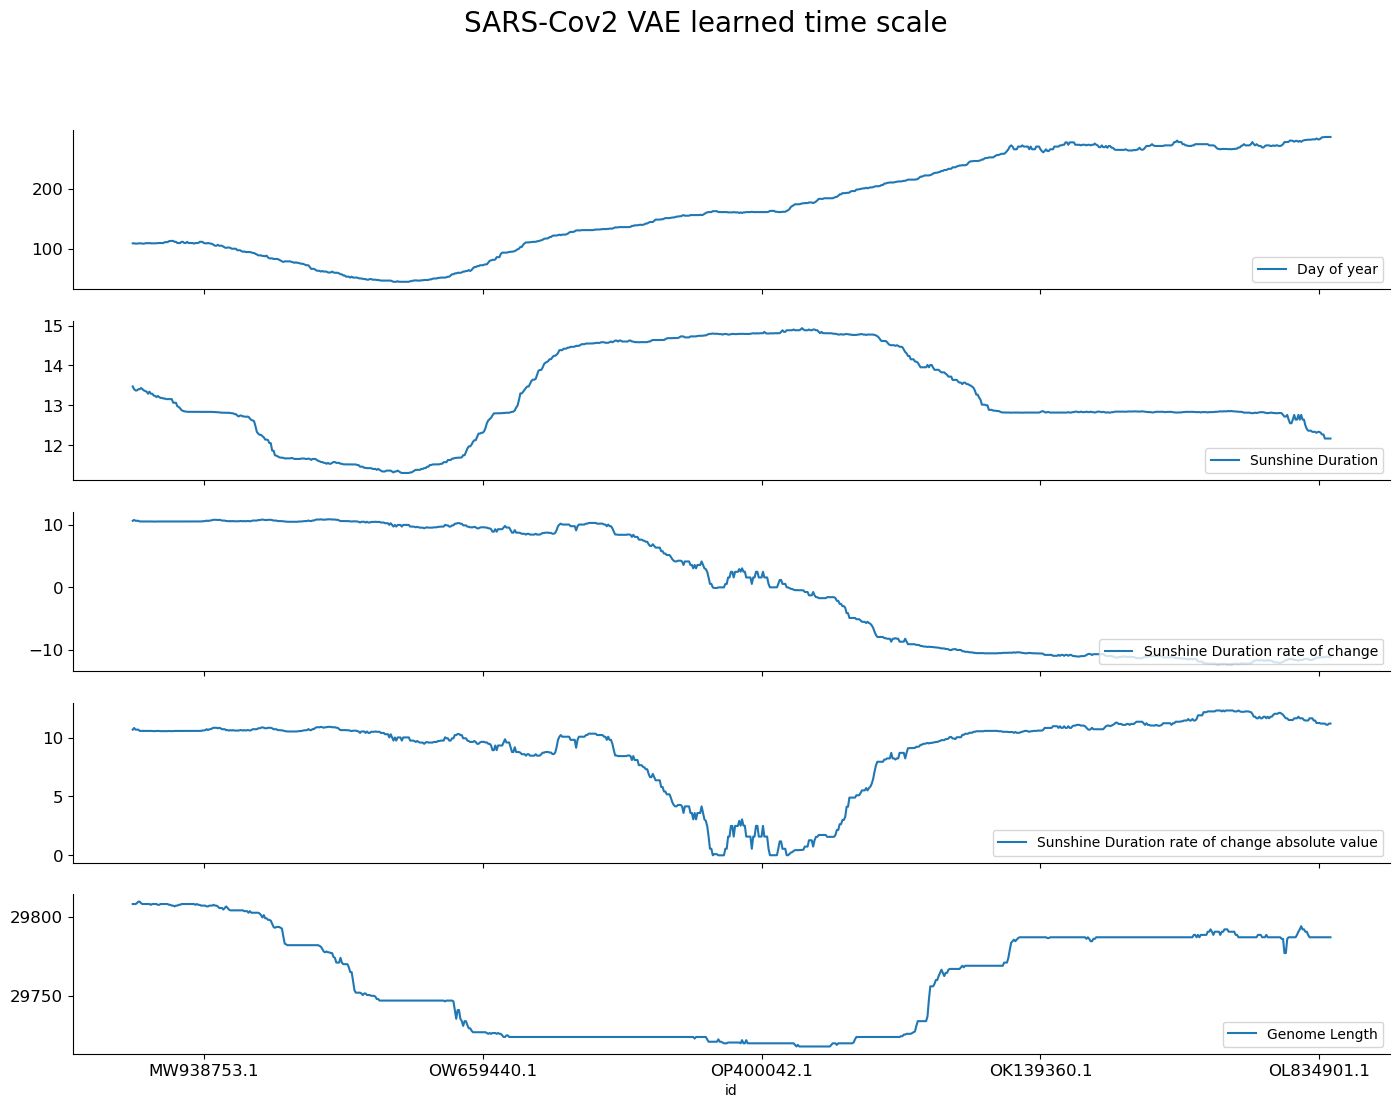

In [9]:
order = np.argsort(VariationalRep[:,1])
ordval = np.array([val for val in order if np.abs(VariationalRep[val,1])<0.001])
RepData = VariationalRep[ordval]
ord_x = np.argsort(RepData[:,0])

indexOrder = ordval[ord_x]
indexIds = KmerData.iloc[indexOrder].index

MiniData = MetaData.loc[indexIds]

fig,axs =  plt.subplots(5,1,figsize=(17,12),sharex=True)

MiniData['dayofyear'].rolling(150).apply(np.median).plot(ax=axs[0],label='Day of year')
axs[0].legend(loc=4)
PlotStyle(axs[0])
MiniData['lengthofday'].rolling(150).apply(np.median).plot(ax=axs[1],label='Sunshine Duration')
axs[1].legend(loc=4)
PlotStyle(axs[1])
MiniData['lengthofdayd10'].rolling(150).apply(np.median).plot(ax=axs[2],label='Sunshine Duration rate of change')
axs[2].legend(loc=4)
PlotStyle(axs[2])
MiniData['lengthofdayd10'].rolling(150).apply(np.median).abs().plot(ax=axs[3],label='Sunshine Duration rate of change absolute value')
axs[3].legend(loc=4)
PlotStyle(axs[3])
MiniData['Length'].rolling(150).apply(np.median).abs().plot(ax=axs[4],label='Genome Length')
axs[4].legend(loc=4)
PlotStyle(axs[4])
fig.suptitle('SARS-Cov2 VAE learned time scale ',fontsize=20)

# Multiple sequence alignment

In [10]:
basePath = '/kaggle/input/covid19-sequences-fasta/single/single'
seqPaths = [basePath+'/'+fil+'.fasta' for fil in MiniData.index]

seqs = [GetSeq(val) for val in seqPaths]

maxSeq = max([len(val.seq) for val in seqs])

localDict = {}

for k,val in enumerate(Alphabet):
    localDict[val]=k+1

CodedSeqs = [[localDict[val] for val in sal.seq] + [0 for _ in range(maxSeq-len(sal.seq))] for sal in seqs]
CodedSeqs = np.array(CodedSeqs)

Text(0.5, 0.98, 'Sorted SARS-Cov2 sequences \n (each plot represents 5000 genome bases from top to bottom)')

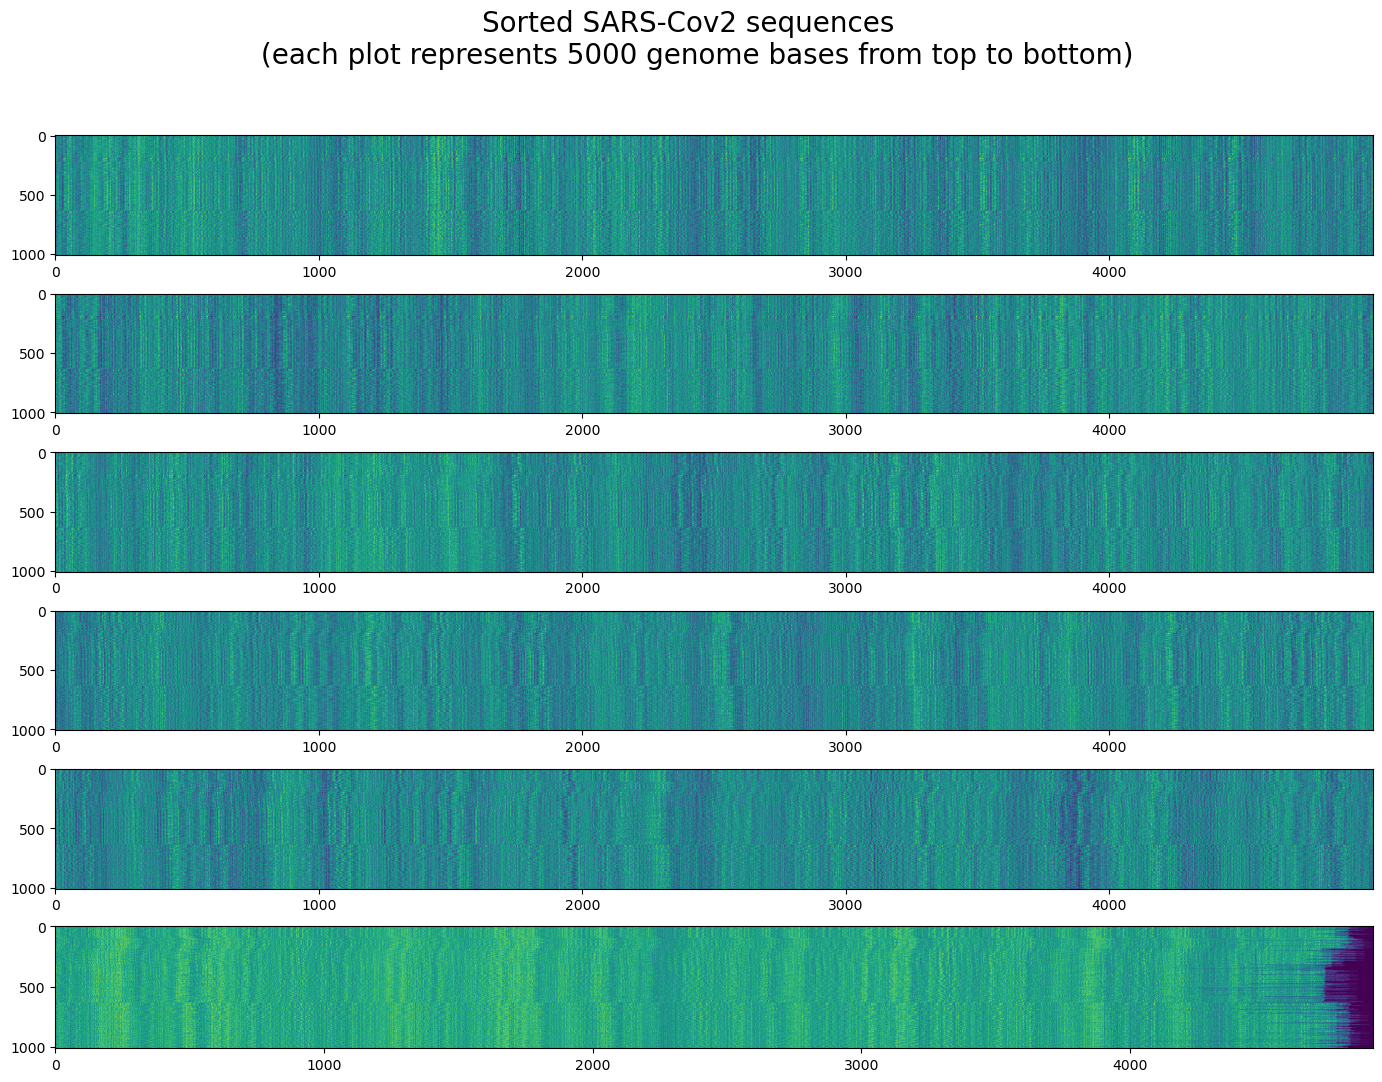

In [11]:
fig,axs =  plt.subplots(6,1,figsize=(17,12))

for k in range(6):
    axs[k].imshow(CodedSeqs[:,k*5000:(k+1)*5000],aspect=0.45)

fig.suptitle('Sorted SARS-Cov2 sequences \n (each plot represents 5000 genome bases from top to bottom)',fontsize=20)

In [12]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(VariationalRep[:,0].reshape(-1,1))
s = np.linspace(-3,4)
e = kde.score_samples(s.reshape(-1,1))

mi = argrelextrema(e, np.less)[0]
positions = [-4]+[s[val] for val in mi]

def GetCluster(sample,positions=positions):
    
    out = -1
    for k in range(len(positions)-1):
        if sample <= positions[k+1] and sample >= positions[k]:
            out = k
            break
    return out
        
MetaData['cluster'] = MetaData['ldim0'].map(GetCluster)

UniqueLineages = MetaData['Pangolin'].unique()
VertMins = []
VertMaxs = []

for val in UniqueLineages:
    lData = MetaData[MetaData['Pangolin']==val]['dayofyear']
    VertMins.append(lData.min())
    VertMaxs.append(lData.max())

# Mutational Hot spots

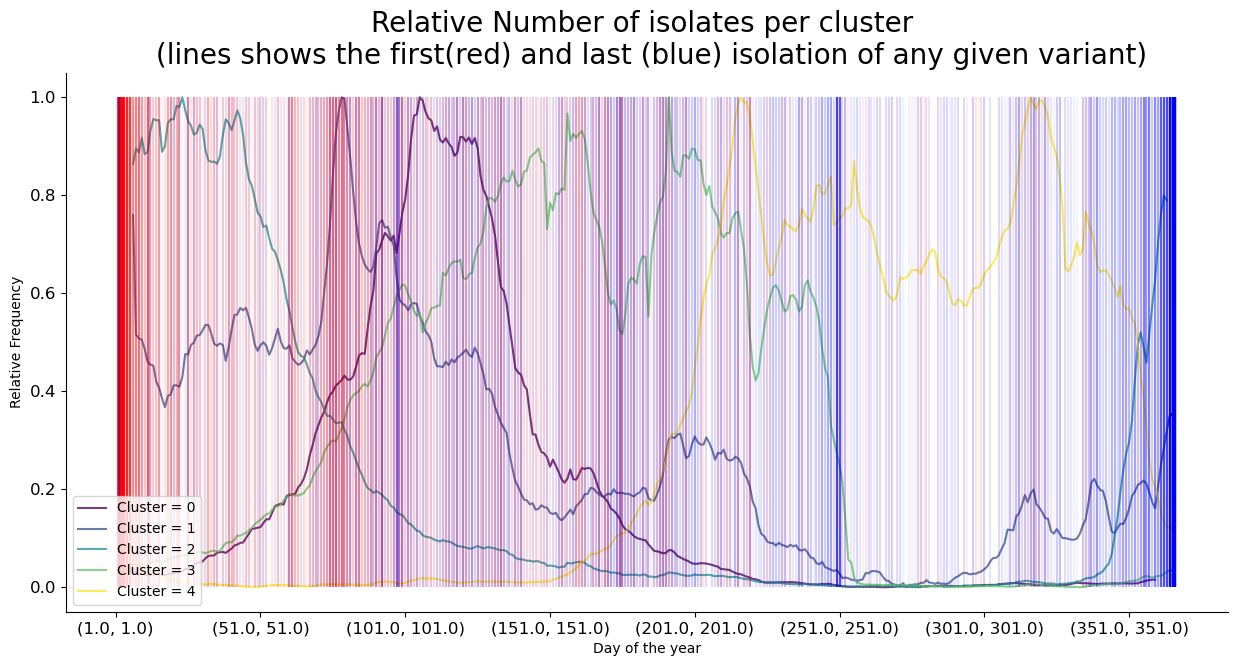

In [13]:
plt.figure(figsize=(15,7))

colrs = [plt.cm.viridis(val) for val in np.linspace(0,1,5)]

for k in range(5):
    dta = MetaData[MetaData['cluster']==k].groupby('dayofyear')['dayofyear'].value_counts().rolling(7).mean()
    dta = (dta-dta.min())/(dta.max()-dta.min())
    dta.plot(color=colrs[k],label='Cluster = '+str(k),alpha=0.75)

ax = plt.gca()
ax.legend(loc=3)
ax = plt.gca()
ax.vlines(VertMins, 0, 1,color='red',alpha=0.05)
ax.vlines(VertMaxs, 0, 1,color='blue',alpha=0.05)
ax.set_xlabel('Day of the year')
ax.set_ylabel('Relative Frequency')
ax.set_title('Relative Number of isolates per cluster \n (lines shows the first(red) and last (blue) isolation of any given variant)',fontsize=20)
PlotStyle(ax)

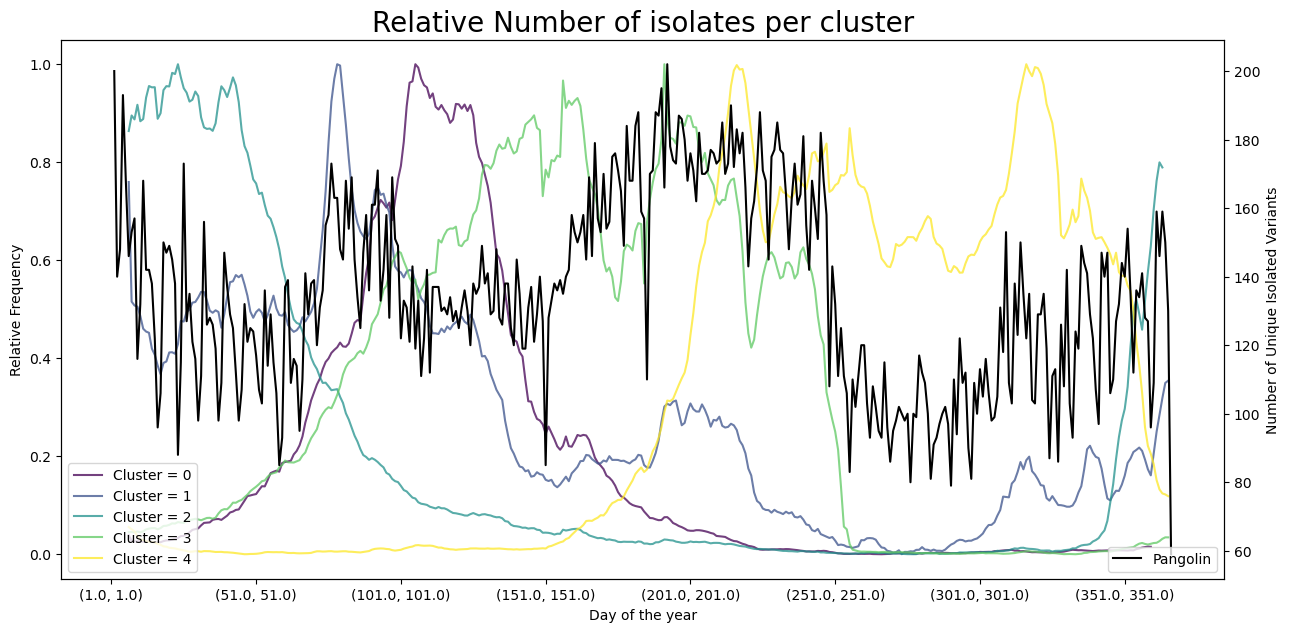

In [14]:
plt.figure(figsize=(15,7))

colrs = [plt.cm.viridis(val) for val in np.linspace(0,1,5)]

for k in range(5):
    dta = MetaData[MetaData['cluster']==k].groupby('dayofyear')['dayofyear'].value_counts().rolling(7).mean()
    dta = (dta-dta.min())/(dta.max()-dta.min())
    dta.plot(color=colrs[k],alpha=0.75,label='Cluster = '+str(k))

ax = plt.gca()
ax.legend(loc=3)
ax.set_xlabel('Day of the year')
ax.set_ylabel('Relative Frequency')
ax.set_title('Relative Number of isolates per cluster',fontsize=20)

ax2 = ax.twinx()
MetaData.groupby('dayofyear')['Pangolin'].nunique().plot(ax=ax2,color='black')
ax2.set_ylabel('Number of Unique Isolated Variants')
ax2.legend(loc=4)